In [273]:
import dgl
import gluoncv as gcv
import mxnet as mx
import numpy as np
import logging, time
from operator import itemgetter
from mxnet import nd, gluon
from mxnet.gluon import nn
from dgl.utils import toindex
from dgl.nn.mxnet import GraphConv
from gluoncv.model_zoo import get_model

In [274]:
class SoftmaxHD(nn.HybridBlock):
    """Softmax on multiple dimensions
    Parameters
    ----------
    axis : the axis for softmax normalization
    """
    def __init__(self, axis=(2, 3), **kwargs):
        super(SoftmaxHD, self).__init__(**kwargs)
        self.axis = axis

    def hybrid_forward(self, F, x):
        x_max = F.max(x, axis=self.axis, keepdims=True)
        x_exp = F.exp(F.broadcast_minus(x, x_max))
        norm = F.sum(x_exp, axis=self.axis, keepdims=True)
        res = F.broadcast_div(x_exp, norm)
        return res

class EdgeLinkMLP(nn.Block):
    def __init__(self, n_hidden, n_classes):
        super(EdgeLinkMLP, self).__init__()
        self.mlp1 = nn.Dense(n_hidden)
        self.relu = nn.Activation('relu')
        self.mlp2 = nn.Dense(n_classes)

    def forward(self, edges):
        feat = nd.concat(edges.src['node_class_vec'], edges.src['bbox'],
                         edges.dst['node_class_vec'], edges.dst['bbox'])
        out = self.relu(self.mlp1(feat))
        out = self.mlp2(out)
        return {'link_preds': out}

class EdgeMLP(nn.Block):
    def __init__(self, n_hidden, n_classes):
        super(EdgeMLP, self).__init__()
        self.mlp1 = nn.Dense(n_hidden)
        self.relu1 = nn.Activation('relu')
        self.mlp2 = nn.Dense(n_hidden)
        self.relu2 = nn.Activation('relu')
        self.mlp3 = nn.Dense(n_classes)

    def forward(self, edges):
        feat = nd.concat(edges.src['node_class_vec'], edges.src['emb'], edges.src['bbox'],
                         edges.dst['node_class_vec'], edges.src['emb'], edges.dst['bbox'])
        out = self.relu1(self.mlp1(feat))
        out = self.relu2(self.mlp2(out))
        out = self.mlp3(out)
        return {'preds': out}

class EdgeGCN(nn.Block):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_obj_classes,
                 n_layers,
                 activation,
                 box_feat_ext,
                 pretrained_base=True,
                 ctx=mx.cpu()):
        super(EdgeGCN, self).__init__()
        self.layers = nn.Sequential()
        # input layer
        self.layers.add(GraphConv(in_feats, n_hidden, activation=activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.add(GraphConv(n_hidden, n_hidden, activation=activation))
        # output layer
        self.edge_link_mlp = EdgeLinkMLP(50, 2)
        self.edge_mlp = EdgeMLP(100, n_classes)
        self._box_feat_ext = get_model(box_feat_ext, pretrained=pretrained_base, ctx=ctx).features[:-2]
        self._softmax = SoftmaxHD(axis=(1))

    def forward(self, g):
        if g is None or g.number_of_nodes() == 0:
            return g
        # cls = g.ndata['node_class_pred']
        # g.ndata['node_class_prob'] = self._softmax(cls)
        # link pred
        g.ndata['node_class_vec'] = self._softmax(g.ndata['node_class_pred'])
        g.apply_edges(self.edge_link_mlp)
        # graph conv
        x = self._box_feat_ext(g.ndata['images'])
        x = x.sum(axis=1).reshape((0, -1))
        for i, layer in enumerate(self.layers):
            x = layer(g, x)
        g.ndata['emb'] = x
        # link classification
        g.apply_edges(self.edge_mlp)
        return g

In [275]:
N_relations = 50
N_objects = 150
ctx=mx.cpu()

net = EdgeGCN(in_feats=49, n_hidden=32, n_classes=N_relations, n_obj_classes=N_objects,
              n_layers=3, activation=nd.relu,
              box_feat_ext='mobilenet1.0', pretrained_base=False, ctx=ctx)
'''
# net.initialize(ctx=ctx)
net._box_feat_ext.hybridize()
net.edge_mlp.initialize(ctx=ctx)
net.edge_link_mlp.initialize(ctx=ctx)
net.layers.initialize(ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'adam',
                        {'learning_rate': 0.01, 'wd': 0.00001})
for k, v in net._box_feat_ext.collect_params().items():
    v.grad_req = 'null'
'''
net.load_parameters('params/model-9.params', ctx=ctx)

In [276]:
@mx.metric.register
@mx.metric.alias('auc')
class AUCMetric(mx.metric.EvalMetric):
    def __init__(self, eps=1e-12):
        super(AUCMetric, self).__init__(
              'auc')
        self.eps = eps

    def update(self, labels, preds):
        mx.metric.check_label_shapes(labels, preds)
        label_weight = labels[0].asnumpy()
        preds = preds[0].asnumpy()
        tmp = []
        for i in range(preds.shape[0]):
            tmp.append((label_weight[i], preds[i][1]))
        tmp = sorted(tmp, key=itemgetter(1), reverse=True)
        label_sum = label_weight.sum()
        if label_sum == 0 or label_sum == label_weight.size:
            raise Exception("AUC with one class is undefined")

        label_one_num = np.count_nonzero(label_weight)
        label_zero_num = len(label_weight) - label_one_num
        total_area = label_zero_num * label_one_num
        height = 0
        width = 0
        area = 0
        for a, _ in tmp:
            if a == 1.0:
                height += 1.0
            else:
                width += 1.0
                area += height

        self.sum_metric += area / total_area
        self.num_inst += 1

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/registry.py:109: UserWarning: New metric __main__.AUCMetric registered with name auc isoverriding existing metric __main__.AUCMetric
  register(klass, name)
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: New metric __main__.AUCMetric registered with name aucmetric isoverriding existing metric __main__.AUCMetric
  app.launch_new_instance()


In [277]:
def _build_complete_graph(bbox, scores, img, feat_ind, cls_pred, thr=0.5):
    bbox_list = []
    bbox_np_list = []
    roi_ind = []
    detect_ind = []
    for i in range(bbox.shape[0]):
        if scores[i] > thr:
            detect_ind.append(i)
            bbox_list.append(bbox[i])
            bbox_np_list.append(bbox[i].asnumpy())
            roi_ind.append(i)

    N = len(bbox_list)
    bbox = mx.nd.stack(*bbox_list)
    g = dgl.DGLGraph()
    g.add_nodes(N)
    edge_list = []
    for i in range(N-1):
        for j in range(i+1, N):
            edge_list.append((i, j))
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    g.add_edges(dst, src)

    img_list = crop_resize_normalize(img, bbox_np_list, (224, 224))
    node_imgs = mx.nd.stack(*img_list)

    img_shape = x.shape
    bbox[:,0] /= img_shape[3]
    bbox[:,1] /= img_shape[2]
    bbox[:,2] /= img_shape[3]
    bbox[:,3] /= img_shape[2]
    g.ndata['bbox'] = bbox
    g.ndata['images'] = node_imgs
    g.ndata['node_class_pred'] = cls_pred[roi_ind,0:150]
    return g, detect_ind

In [278]:
vg_val = gcv.data.VGRelation(top_frequent_rel=N_relations, top_frequent_obj=N_objects,
                             balancing='weight', split='val')

In [279]:
from gluoncv.data import dataloader
val_data = gluon.data.DataLoader(vg_val, batch_size=batch_size, shuffle=False, num_workers=60,
                                 batchify_fn=dataloader.dgl_mp_batchify_fn)
class_names = vg_val._obj_classes
rel_names = vg_val._relations

In [280]:
detector = get_model('faster_rcnn_resnet50_v1b_custom', classes=class_names,
                     pretrained_base=False, pretrained=False, additional_output=True)
params_path = 'faster_rcnn_resnet50_v1b_custom_0007_0.2398.params'
detector.load_parameters(params_path, ctx=ctx, ignore_extra=True, allow_missing=True)

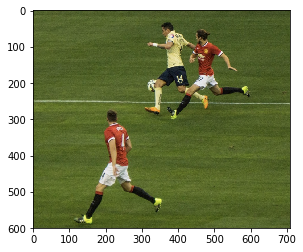

In [281]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cv2

x, orig_img = gcv.data.transforms.presets.rcnn.load_test('soccer.png')

plt.imshow(orig_img)
plt.show()

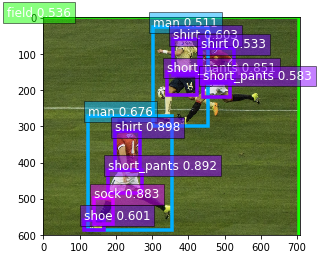

In [43]:
box_ids, scores, bboxes, feat, feat_ind, spatial_feat, cls_pred = detector(x)
ax = gcv.utils.viz.plot_bbox(orig_img, bboxes[0], scores[0], box_ids[0], class_names=class_names)

plt.show()

In [219]:
from gluoncv.data.transforms.pose import crop_resize_normalize
g, detection_ind = _build_complete_graph(bboxes[0], scores[0], orig_img, feat_ind[0], cls_pred[0])

In [220]:
g

DGLGraph(num_nodes=11, num_edges=110,
         ndata_schemes={'bbox': Scheme(shape=(4,), dtype=<class 'numpy.float32'>), 'images': Scheme(shape=(3, 224, 224), dtype=<class 'numpy.float32'>), 'node_class_pred': Scheme(shape=(150,), dtype=<class 'numpy.float32'>)}
         edata_schemes={})

In [221]:
g = net(g)

In [222]:
g

DGLGraph(num_nodes=11, num_edges=110,
         ndata_schemes={'bbox': Scheme(shape=(4,), dtype=<class 'numpy.float32'>), 'images': Scheme(shape=(3, 224, 224), dtype=<class 'numpy.float32'>), 'node_class_pred': Scheme(shape=(150,), dtype=<class 'numpy.float32'>), 'node_class_vec': Scheme(shape=(150,), dtype=<class 'numpy.float32'>), 'emb': Scheme(shape=(32,), dtype=<class 'numpy.float32'>)}
         edata_schemes={'link_preds': Scheme(shape=(2,), dtype=<class 'numpy.float32'>), 'preds': Scheme(shape=(50,), dtype=<class 'numpy.float32'>)})

In [259]:
link_prob = nd.softmax(g.edata['link_preds'])[:,1].asnumpy()
prob_thresh = 0.1
eid_above_thresh = np.where(link_prob > prob_thresh)[0]
eid = link_prob.argsort()[::-1][0:len(eid_above_thresh)]

In [260]:
node_ids = g.find_edges(eid)
node_src = node_ids[0].asnumpy()
node_dst = node_ids[1].asnumpy()

shirt along man

Probability of the subject being shirt is 0.898298
Probability of the object being man is 0.675927
Probability of having the link is 0.588263
Probability of the link being along is 0.544044


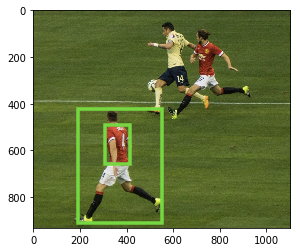

In [286]:
i = 2
bbox_ind = [node_src[i], node_dst[i]]

sub_node_ind = int(box_ids[0][detect_ind[node_src[i]]].asscalar())
ob_node_ind = int(box_ids[0][detect_ind[node_dst[i]]].asscalar())
sub = class_names[sub_node_ind]
ob = class_names[ob_node_ind]

rel_prob = nd.softmax(g.edata['preds'][eid[i]]).asnumpy()
rel_ind = int(rel_prob.argmax())
rel = rel_names[rel_ind]

print("%s %s %s\n"%(sub, rel, ob))
print('Probability of the subject being %s is %f'%(sub, scores[0, detect_ind[node_src[i]], 0].asscalar()))
print('Probability of the object being %s is %f'%(ob, scores[0, detect_ind[node_dst[i]], 0].asscalar()))
print('Probability of having the link is %f'%(link_prob[eid[i]]))
print('Probability of the link being %s is %f'%(rel, rel_prob[rel_ind]))


ax = gcv.utils.viz.plot_bbox(img, mx.nd.array(g.ndata['bbox'][bbox_ind,:]), absolute_coordinates=False)
plt.show()

In [264]:
scores[0, detect_ind[node_src[i]], 0].asscalar()

0.602755